In [154]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from statsmodels import api as sm
np.seterr(divide='ignore', invalid='ignore')
df = pd.read_csv("/Users/erenanbar/Desktop/internship_project/data_small/ticketData_vs_max_interference_202308141556.csv")
df.head(5)


,day,modelName,interface,max_intf_score,ticket_size,total_size
0,2023-03-01,Arcadyan eLife Connect C1AA,0,0.00,0,1744
1,2023-03-01,Arcadyan eLife Connect C1AA,0,0.01,0,2778
2,2023-03-01,Arcadyan eLife Connect C1AA,0,0.02,0,891
3,2023-03-01,Arcadyan eLife Connect C1AA,0,0.03,0,741
4,2023-03-01,Arcadyan eLife Connect C1AA,0,0.04,0,828


In [155]:
df = df.groupby(['interface','modelName','max_intf_score']).agg({'ticket_size':'sum','total_size':'sum'}).reset_index()
df['call_prob'] = df['ticket_size']/df['total_size']
df['call_prob'] = df['call_prob'].fillna(0)
df

,interface,modelName,max_intf_score,ticket_size,total_size,call_prob
0,0,Arcadyan eLife Connect C1AA,0.00,0,42940,0.0
1,0,Arcadyan eLife Connect C1AA,0.01,0,69231,0.0
2,0,Arcadyan eLife Connect C1AA,0.02,0,24956,0.0
3,0,Arcadyan eLife Connect C1AA,0.03,0,18504,0.0
4,0,Arcadyan eLife Connect C1AA,0.04,0,22123,0.0
...,...,...,...,...,...,...
1300,32,etisalat_sercomm_s3_mtk_ccprpl,0.03,0,3,0.0
1301,32,etisalat_sercomm_s3_mtk_ccprpl,0.04,0,2,0.0
1302,32,etisalat_sercomm_s3_mtk_ccprpl,0.05,0,2,0.0
1303,32,etisalat_sercomm_s3_mtk_ccprpl,0.10,0,1,0.0


In [158]:
df_grouped = df.groupby(['interface','modelName'])

for interface in df['interface'].unique():
    for model in df['modelName'].unique():
        mask = ((df['interface'] == interface)&
                (df['modelName'] == model))
        arr = df.loc[mask,'call_prob']
        for i in range(0,len(arr),1):
            if (df.loc[mask,'call_prob'][i+1] < df.loc[mask,'call_prob'][i]):
                df.loc[mask,'call_prob'][i+1] = df.loc[mask,'call_prob'][i]
            
plt.plot(df.loc[(df['interface'] == 32) & (df['modelName'] == 'Arcadyan eLife Connect C1AA'), "max_intf_score"], 
         df.loc[(df['interface'] == 32) & (df['modelName'] == 'Arcadyan eLife Connect C1AA'), "call_prob"])
    

KeyError: 101

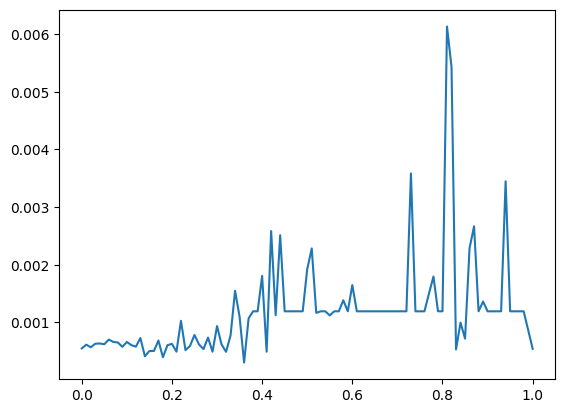

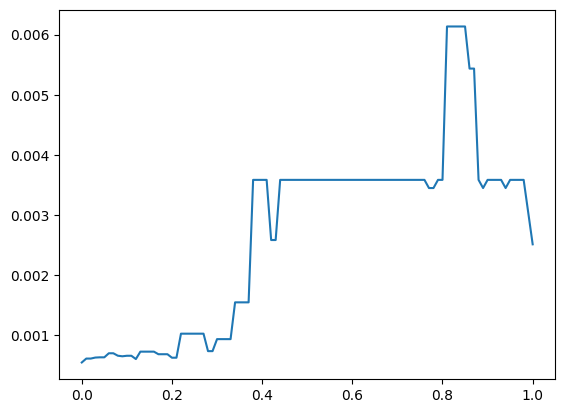

In [ ]:
plt.plot(df.loc[(df['interface'] == 32) & (df['modelName'] == 'Etisalat-S3'), "max_intf_score"], 
         df.loc[(df['interface'] == 32) & (df['modelName'] == 'Etisalat-S3'), "call_prob"])
         
plt.plot(df.loc[(df['interface'] == 32) & (df['modelName'] == 'Etisalat-S3'), "max_intf_score"], 
         df.loc[(df['interface'] == 32) & (df['modelName'] == 'Etisalat-S3'), "prob_predict"])

In [ ]:


isoR = IsotonicRegression(
        y_min=0,
        y_max=1,
        increasing=True,
        out_of_bounds="clip")

df_grouped = df.groupby(['interface','modelName'])
for interface_model, data in df_grouped:
    interface, modelName = interface_model[0],interface_model[1]
    x_train = data['max_intf_score']
    y_train = data['ticket_prob']
    isoR_intscore = isoR.fit(x_train, y_train)
    train_prediction = isoR_intscore.predict(x_train)
    train_prediction_smoothed = sm.nonparametric.lowess(
    train_prediction, x_train, frac=0.3)[:, 1]
    df.loc[(df['interface'] == interface) & (df['modelName'] == modelName), "prob_isoR"] = train_prediction
    df.loc[(df['interface'] == interface) & (df['modelName'] == modelName), "prob_isoR_smoothed"] = train_prediction_smoothed
    
#enter interface and model to plot
interface_model = (0,'DLink DIR-853/ET')

score_column = df_grouped.get_group((interface_model[0],interface_model[1]))['max_intf_score']
predict_column = df_grouped.get_group((interface_model[0],interface_model[1]))['prob_isoR_smoothed']
train_column = df_grouped.get_group((interface_model[0],interface_model[1]))['ticket_prob']

plt.plot(score_column,train_column,label='prob_train')
plt.plot(score_column,predict_column,label='prob_predict')
plt.xlabel('intf_score')
plt.ylabel('prob')
plt.title('interface: ' + str(interface_model[0]) + ' Model name: ' + interface_model[1] )
plt.legend()
plt.show()